<font style="font-family:'Times New Roman';font-size:20px">

The way a machine learning model fits itself to data is governed by a set of initial conditions called hyperparameters. Hyperparameters help to restrict the learning behavior of a model so that it will (hopefully) be able to fit the data well and within a reasonable amount of time. Finding the best set of hyperparameters (often called “tuning”) is one of the most important and time consuming parts of the modeling task. Historical approaches to hyperparameter tuning involve either a brute force or random search over a grid of hyperparameter combinations called Grid Search and Random Search, respectively. Although popular, Grid and Random Search methods lack any way of converging to a decent set of hyperparameters — that is, they are purely trial and error. In this article we will tackle a relatively new approach for hyperparameter tuning — the Tree-Structured Parzen Estimator (TPE) — and understand its function programmatically through a step-by-step implementation in Python.

TPE is a Bayesian optimization algorithm. This means it allows us to start with some initial beliefs about what our best model hyperparameters are, and update these beliefs in a principled way as we learn how different hyperparameters impact model performance. This is already a significant improvement over Grid Search and Random Search! Instead of determining the best hyperparameter set through trial and error, over time we can try more combinations of hyperparameters which lead to good models and fewer that do not.

TPE gets its name from two main ideas: 1. using Parzen Estimation to model our beliefs about the best hyperparameters (more on this later) and 2. using a tree-like data structure called a posterior-inference graph to optimize the algorithm runtime. In this example we will ignore the “tree-structured” part as it has nothing to do with hyperparameter tuning per se. Additionally, we will not go into the blow by blow of Bayesian statistics, expected improvement, etc. The goal here is to develop a high-level conceptual understanding of TPE and how it works. For a more thorough treatment of these topics see the original paper on TPE by J. Bergstra and colleagues.
</font>

## Setting Up The Example

<font style="font-family:'Times New Roman';font-size:20px">
To build our implementation of TPE, we will need a toy example to work with. Let’s imagine we want to find the line of best-fit through some randomly generated data. In this example, we have two hyperparameters to tune — the line slope m and intercept b.
</font>

In [1]:
import numpy as np

MIN_M, MAX_M = 10, 100
MIN_B, MAX_B = -6000, -3000

np.random.seed(20230926)
x = np.linspace(0, 100, 1000)
m = np.random.randint(MIN_M, MAX_M)
b = np.random.randint(MIN_B, MAX_B)
y = m*x + b + np.random.randn(1000)*700

<Axes: xlabel='X', ylabel='Y'>

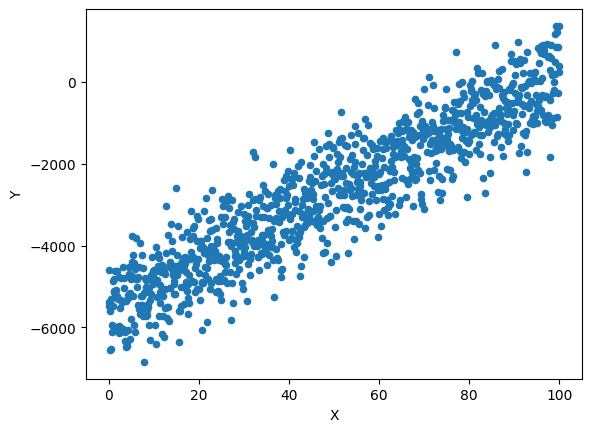

In [2]:
import pandas as pd

df = pd.DataFrame()
df["X"] = x
df["Y"] = y
df.plot.scatter(x="X", y="Y")
# df

<font style="font-family:'Times New Roman';font-size:20px">
Since TPE is an optimization algorithm we also need some metric to optimize over. We will use root mean-squared error (RMSE). Let’s define the function rmse to calculate this metric as follows:
</font>

In [3]:
def rmse(m, b):
    preds = m*x+b
    return np.sqrt(((preds - y)**2).sum()/len(preds))


<font style="font-family:'Times New Roman';font-size:20px">
The last thing we will need is some initial beliefs about what our best hyperparameters are. Let’s say we believe that the slope of the line of best-fit is a uniform random variable on the interval (10,100) and intercept is also a uniform random variable on the interval (-6000, -3000). These distributions are called priors. That they are uniform random variables is equivalent to saying we believe the true values of the best hyperparameters are equally likely to lie anywhere within their respective intervals. We will implement a class to encapsulate these variables, and use them to define our initial search space.
</font>

In [4]:
class UniformDist:

  def __init__(self, min_, max_):
    self.min = min_
    self.max = max_

  def sample(self, n_samples):
    return np.random.uniform(self.min, self.max, n_samples)


In [5]:
search_space = {"m": UniformDist(10, 100), "b": UniformDist(-6000, -3000)}

<font style="font-family:'Times New Roman';font-size:20px">
With all this set up complete, we can move on to coding the algorithm itself.
</font>

# Step 1: Random Exploration

<font style="font-family:'Times New Roman';font-size:20px">
The first step of TPE is to randomly sample sets of hyperparameters from our priors. This process gives us a first approximation of where the areas of our search space are that produce good models. The function sample_priors consumes our initial search space and a number of random samples to draw from it. It then evaluates the resulting models using our objective function rmse and returns a Pandas DataFrame containing the slope, intercept, and RMSE of each trial.
</font>

In [6]:
def sample_priors(space, n_samples):

    seed = np.array([space[hp].sample(n_samples) for hp in space])

    seed_rmse = np.array([rmse(m, b) for m, b in seed.T])

    data = np.stack([seed[0], seed[1], seed_rmse]).T
    trials = pd.DataFrame(data, columns=["m", "b", "rmse"])

    return trials


<Axes: xlabel='m', ylabel='b'>

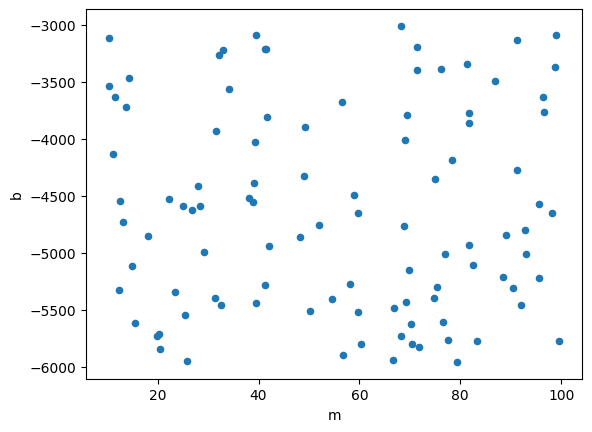

In [7]:
df = sample_priors(search_space, 100)
df.plot.scatter(x="m", y="b")

# Step 2: Partitioning the Search Space and Parzen Estimation

<font style="font-family:'Times New Roman';font-size:20px">
After generating some initial samples from our priors, we now split our hyperparameter search space in two using a quantile threshold γ, where γ is between 0 and 1. Let’s arbitrarily choose γ=0.2. Hyperparameter combinations which result in a model that performs in the top 20% of all models we have created thus far get grouped into a “good” distribution l(x). All other hyperparameter combinations belong to a “bad” distribution g(x).
</font>

In [8]:
sorted = df["rmse"].sort_values()
threshold = sorted[int(0.2*len(sorted))]
threshold

2272.639596517373

<Axes: xlabel='m', ylabel='b'>

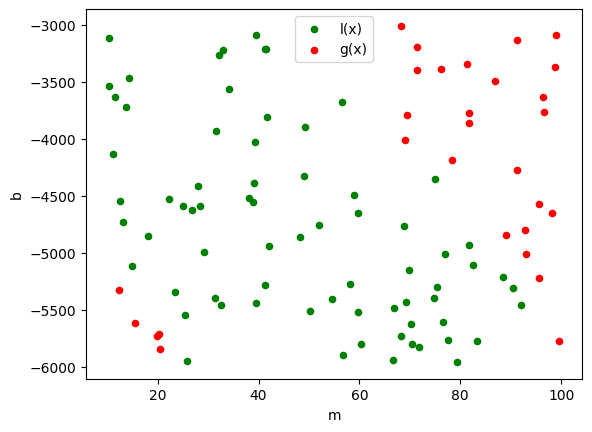

In [9]:
ax = df[df["rmse"] <= threshold].plot.scatter(x="m", y="b", color="green", label="l(x)")
df[df["rmse"] > threshold].plot.scatter(x="m", y="b", color="red", label="g(x)", ax=ax)

<font style="font-family:'Times New Roman';font-size:20px">
It turns out that the best next combination of our hyperparameters to test is given by the maximum of g(x)/l(x) (if you would like to see the derivation of this see [1](https://proceedings.neurips.cc/paper/2011/hash/86e8f7ab32cfd12577bc2619bc635690-Abstract.html)). This intuitively makes sense. We want hyperparameters which are highly likely under our “good” distribution l(x) and not very likely under our “bad” distribution g(x). We can model each of g(x) and l(x) using Parzen Estimators which is where the “PE” in “TPE” comes from. The rough idea of Parzen Estimation a.k.a. Kernel Density Estimation (or KDE) is that we are going to average across a series of normal distributions each centered on an observation belonging to g(x) or l(x) (respectively). The resulting distributions have high density over regions of our search space where samples are close together and low density over regions where samples are far apart. To perform Parzen Estimation we will use the KernelDensity object from the SKLearn library. The function segment_distributions consumes our trials DataFrame and our threshold γ and returns a Parzen Estimator for l(x) and g(x) each.
</font> 

In [10]:
from sklearn.neighbors import KernelDensity

def segment_distributions(trials, gamma):

    """Splits samples into l(x) and g(x) distributions based on our quantile cutoff gamma (using rmse as criteria).
    Returns a kernel density estimator (KDE) for l(x) and g(x), respectively."""

    cut = np.quantile(trials["rmse"], gamma)

    l_x = trials[trials["rmse"] < cut][["m", "b"]]
    g_x = trials[~trials.isin(l_x)][["m", "b"]].dropna()

    l_kde = KernelDensity(kernel="gaussian", bandwidth=5.0)
    g_kde = KernelDensity(kernel="gaussian", bandwidth=5.0)

    l_kde.fit(l_x.to_numpy())
    g_kde.fit(g_x.to_numpy())

    return l_kde, g_kde
    

# Step 3: Determining the Next “Best” Hyperparameters to Test

<font style="font-family:'Times New Roman';font-size:20px">
As mentioned in Step 2, the next best set of hyperparameters to test maximize g(x)/l(x). We can determine what this set of hyperparameters are in the following way. First we draw N random samples from l(x). Then for each of those samples we evaluate their log-likelihood with respect to l(x) and g(x), selecting the sample which maximizes g(x)/l(x) as the next hyperparameter combination to test. The SKLearn `KernelDensity` implementation we decided to use makes this computation very easy.
</font>

In [11]:
def choose_next_hps(l_kde, g_kde, n_samples):
    """Consumes KDEs for l(x) and g(x), samples from l(x) and evaluates each sample with respect to g(x)/l(x).
    The sample which maximizes this quantity is returned as the next set of hyperparameters to test."""

    samples = l_kde.sample(n_samples)

    l_score = l_kde.score_samples(samples)
    g_score = g_kde.score_samples(samples)

    hps = samples[np.argmax(g_score/l_score)]

    return hps
    

# All Together Now

All that is left for us to do is string all of the previously discussed components together into a single algorithm and we have our implementation of TPE! The decisions we have to make here are how many rounds of random exploration we want to perform, how many total iterations of the algorithm we want to complete, and what our cutoff threshold γ will be (yes, even TPE has hyperparameters). Here are a few things to consider when choosing these quantities.

1. If the “best” set of hyperparameters are not captured by your priors before you start TPE, the algorithm may have a difficult time converging.
2. The more rounds of random exploration you perform, the better your initial approximations of g(x) and l(x) will be, which may improve the results of `tpe`.
3. The higher the value of γ, the fewer samples will end up in l(x). Having only a few samples to use when estimating l(x) may lead to poor hyperparameter selection by `tpe`.

In [12]:
def tpe(space, n_seed, n_total, gamma):

    """Consumes a hyperparameter search space, number of iterations for seeding
    and total number of iterations and performs Bayesian optimization. TPE can be
    sensitive to choice of quantile cutoff, which we control with gamma."""

    trials = sample_priors(space, n_seed)

    for i in range(n_seed, n_total):

        l_kde, g_kde = segment_distributions(trials, gamma)

        hps = choose_next_hps(l_kde, g_kde, 100)

        result = np.concatenate([hps, [rmse(hps[0], hps[1])]])

        # trials = trials.append({col:result[i] for i, col in enumerate(trials.columns)}, ignore_index=True)
        trials = pd.concat([trials, pd.DataFrame({col:result[i] for i, col in enumerate(trials.columns)}, index=pd.RangeIndex(i,i+1))])

    return trials

# Results

To perform TPE over our synthetic data we created previously we run the following:

In [13]:
np.random.seed(20230926)
search_space = {"m": UniformDist(MIN_M, MAX_M), "b": UniformDist(MIN_B, MAX_B)}

df = tpe(search_space, n_seed=40, n_total=512, gamma=0.2)
df

,m,b,rmse
0,91.618995,-3875.463097,3619.139149
1,48.559760,-5000.557290,746.958988
2,81.157248,-3912.496114,3013.210864
3,60.274871,-3493.373005,2329.711984
4,44.659821,-3147.663244,1948.729443
...,...,...,...
507,54.096156,-5306.040055,707.650671
508,52.308823,-5306.394492,708.340294
509,53.564528,-5305.590351,706.329480
510,54.075463,-5306.402747,707.522249


TPE: slope=53.05, intercept=-5306.08
LR:  m=    56.81, b        =-5540.97


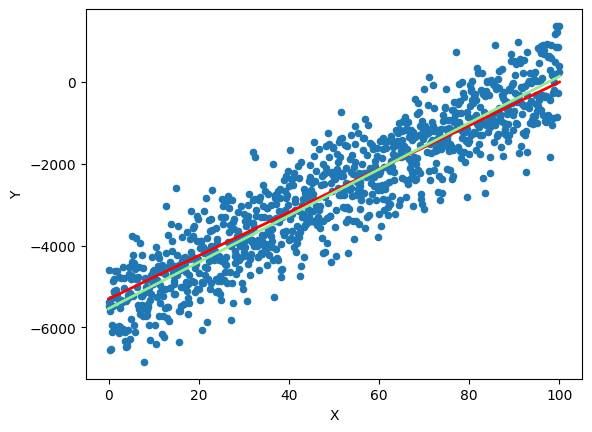

In [22]:
%matplotlib inline
ax = pd.DataFrame({"X":x, "Y":y}).plot.scatter(x="X", y="Y")

import matplotlib.pyplot as plt
slope = df["m"].iat[-1]
intercept = df["b"].iat[-1]
print(f"TPE: {slope=:0.2f}, {intercept=:0.2f}")
plt.plot([0, 100], [intercept, slope*100+intercept], 'r', linewidth=2)

from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(X=x.reshape(-1, 1), y=y.reshape(-1, 1))
pred = lr.predict(np.array([0, 100]).reshape(-1, 1))
plt.plot(np.array([0, 100]), pred, color="lightgreen", linewidth=2)
print(f"LR:  m=    {((pred[1]-pred[0])/100)[0]:0.2f}, b        ={pred[0][0]:0.2f}")

plt.show()

https://towardsdatascience.com/building-a-tree-structured-parzen-estimator-from-scratch-kind-of-20ed31770478